In [1]:
# here we demonstrate how "latent random variables" play an important role in statistical models and thus 
# in the generation of Monte-Carlo simulations.
# Monte-Carlo simulations produce samples from the joint pdf of latent variables and observables (both are random variables).
# To study the marignal pdf of the observables one marginalizes the joint pdf over the latent variable. 

# We use an example from IceCube: Neutral-Current Deep Inelastic Scattering of neutrinos off atomic nuclei.
# A neutrino that interacts through this channel only deposits a fraction of its energy in the detector 
# (as a hadronic shower). This fraction is called inelasticity and typically denoted by y with 0 < y < 1.

# In the problem we have the following variables:
# neutrino energy E_\nu (in this example a constant - but typically a latent variable in other problems)
# deposited energy E_\dep = y * E_\nu (latent random variable)
# reconstructed energy E_\rec (observable random variable)
# inelasticity y (latent random variable)

# We are interested in computing the pdf of the reconstructed energy (observable) f(E_rec)
# We do this at fixed neutrino energy (corresponding to a monoenergetic neutrino beam).
# If the neutrino energy itself is a latent random variable that is generated from some flux
# what we compute would actually be the conditional pdf f(E_rec | E_nu)

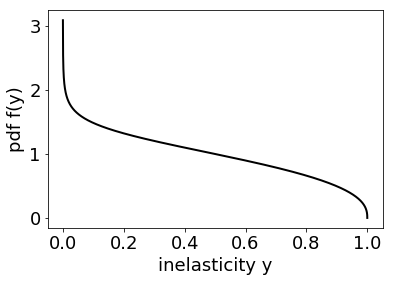

In [11]:
# We first define all relevant pdfs.
# The inelasticity is limited to the interval [0, 1].
# A natural choice for such a random variable would be a beta pdf, which we choose here for simplicity
# (we ignore the physical distribution of y)
# https://en.wikipedia.org/wiki/Beta_distribution

# We choose the parameters a,b such that it behaves somewhat like the physical version in that it peaks towards y=0,\
# decays towards y=1 and has a mean of O(0.1)
# The distribution is shown below.

# in general the distribution depends on E_nu and thus we have f(y | E_nu)
# In our simple problem we assume independence i.e. f(y | E_nu) = f(y)

import numpy as np
from scipy.stats import beta, norm
import matplotlib.pyplot as plt

x = np.linspace(0,1, 10000)
a = 0.9
b = 1.4
y = beta.pdf(x, a, b)
plt.plot(x,y, "k-", linewidth=2)
plt.ylabel("pdf f(y)", fontsize=18)
plt.xlabel("inelasticity y", fontsize=18)
plt.tick_params(labelsize=18)
plt.show()

In [23]:
# We want the joint pdf of all variables
# f(Erec, y | E_nu) = f(Erec | y, E_nu) * f(y | E_nu)
# where f(y | E_nu) = f(y) is the beta pdf
# and f(E_rec | y, E_nu) we assume to be a normal distribution centered at Edep = y * Enu
# with std deviation of 0.1 * Edep

# We can simulate this joint pdf by generating random variables following the hierarchy of conditional pdfs
# We first generate an inelasticity y from the beta pdf (ok - we generate a vector in order to avoid using a for loop)

E_nu = 1.e5 # assume a neutrino energy for 100 TeV = 10^5 GeV

y = np.random.beta(a, b, int(1.e5))

# we now have to generate the reconstructed energy
edep = y * 1.e5 # definition of deposited energy for NC interactions
# generate a vector of reconstructed energies, given the realized values of y we have produced in the previous step
reco_energies = np.random.normal(edep, 0.1 * edep) 

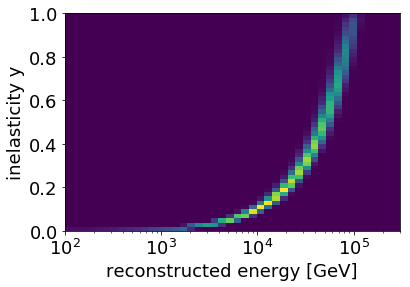

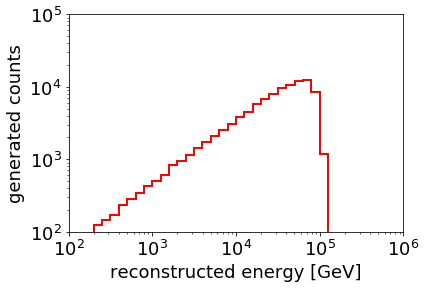

In [29]:
# lets plot the joint pdf of y and E_rec

y_edges = np.linspace(0,1,51)
x_edges = np.linspace(2, 6, 51)
x_edges = 10**x_edges

counts, _, _ = np.histogram2d(reco_energies, y, bins=(x_edges, y_edges))
fig, ax = plt.subplots()
ax.pcolormesh(x_edges, y_edges, counts.T)
ax.set_xscale('log')
ax.set_xlim([100, 3.e5])
ax.set_ylabel("inelasticity y", fontsize=18)
ax.set_xlabel("reconstructed energy [GeV]", fontsize=18)
ax.tick_params(labelsize=18)
plt.show()

# There exists an obvious correlation:
# if the inelasticity is large, than the reconstructed energy will be large
# (the effect of y dominates the 10% resolution of the deposited energy)

# we now have to marginalize over the latent variable y
# discrete marginalization would be to sum all inelasticity bins for fixed energy bin
# to get the total probability content (or total counts) in the energy bin

# it is easy to see that this sum is implicitly done if we just do a histogram of reconstructed energy
# (since events with all possible values of y will contribute to the bin)

edges = np.linspace(2,7,51)
edges = 10 ** edges
plt.hist(reco_energies, bins=edges, histtype='step', color='red', linewidth=2)
plt.xscale('log')
plt.yscale('log')
plt.ylabel("generated counts", fontsize=18)
plt.xlabel("reconstructed energy [GeV]", fontsize=18)
plt.tick_params(labelsize=18)
plt.ylim([10**2, 10**5])
plt.xlim([10**2, 10**6])
plt.show()

# as expected, the reconstructed energy is smaller than the neutrino energy (100 TeV) in this problem.
# (there is tiny probability for E_rec > 100 TeV - this is due to the gaussian width of 10% and thus events with y~1)
# there is a long tail towards small reconstructed energies because the pdf of y peaks towards y=0

In [31]:
# to make the point about marginalization more concrete, let's do it semi-analytically
# we want to find the marginal pdf f(E_rec | E_nu) = \int dy f(E_rec, y | E_nu) = \int dy f(Erec | y, E_nu) * f(y | E_nu)

# we first write down the joint pdf f(E_rec, y | E_nu)
# it reads as follows

def joint_pdf(erec, y):
    enu=1.e5
    edep = y * enu
    # return f(Erec | y, E_nu) * f(y | E_nu)
    return norm.pdf(erec, edep, 0.1 * edep) * beta.pdf(y,a,b)

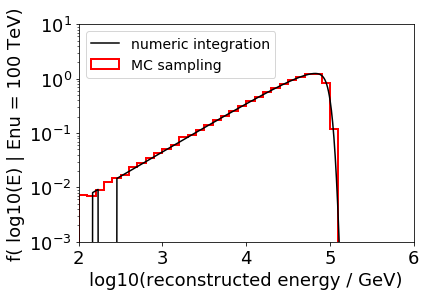

In [34]:
from scipy.integrate import quad

# we evaluate the marginal pdf of E_rec on a grid 
npts = int(1.e3)

pdf_vals = np.zeros(npts)
erec_pts = np.logspace(2,7,npts)
l10 = np.log(10)

# in order to compare to the histogram, we will work with the pdf in log10(E)
# thus we have to transform the pdf onto the log scale
# and then perform the integration over y

for i in range(len(erec_pts)):
    log_erec_pt = np.log10(erec_pts[i]) 
    fint = lambda y: joint_pdf(10**log_erec_pt, y) * 10**log_erec_pt * l10
    pdf_vals[i] = quad(fint, 0, 1)[0] 
    i+=1
    
plt.plot(np.log10(erec_pts), pdf_vals, "k-", label="numeric integration")

edges = np.linspace(2,7,51)
plt.hist(np.log10(reco_energies), bins=edges, histtype='step', density=True, linewidth=2, color='red', label="MC sampling")

plt.yscale('log')
plt.ylim([1.e-3, 10])
plt.xlim([2,6])
plt.ylabel("f( log10(E) | Enu = 100 TeV)", fontsize=18)
plt.xlabel("log10(reconstructed energy / GeV)", fontsize=18)
plt.tick_params(labelsize=18)
plt.legend(fontsize=14)
plt.show()

# observe the match between marginalization via numeric integration (black) and MC sampling (red).